In [615]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import uuid

from scipy.stats import skewnorm

### Helper functions

In [616]:
def seq_along(list: list):
    return range(len(list))

def norm_array(array):
    range = (np.max(array) - np.min(array))
    norm_arr = (array - np.min(array))/max(range, 0.0001)
    return norm_arr

def sample_skew(skew=5, mean=2, sd=15, size=1) -> int:
    """Sample integer(s) from customer item distribution

    Args:
        skew (int, optional): _description_. Defaults to 5.
        mean (int, optional): _description_. Defaults to 2.
        sd (int, optional): _description_. Defaults to 15.
        size (int, optional): _description_. Defaults to 1.

    Returns:
        int: _description_
    """
    # Create distribution
    skewed_dist = skewnorm(skew, mean, sd)
    # Sample from distribution
    skew_num = skewed_dist.rvs(size)
    # Replace negative numbers (and 0) with low positive values 
    strictly_pos = np.where(skew_num < 1, random.randint(1, 10), skew_num)
    # Return integer
    return int(strictly_pos)

### Grocery Classes
1. Customer
2. Cashier
3. Register
4. Store

In [656]:
class Customer:
    
    def __init__(self, store):
        
        self.store = store
        self.register = None
        self.name = uuid.uuid1().hex
        self.items = sample_skew(size=1)
        self.position = random.randint(0, store.n_registers)
        self.vessel = random.choice(["cart", "basket"])

    def register_attributes(self):
        
        active_registers = [reg for reg in self.store.registers if reg.active]

        # DISTANCE IS RELATIVE TO CUSTOMER
        distance_arr = np.array([np.abs(self.position - reg.index) for reg in active_registers]) 
        distance_arr = norm_array(1/(distance_arr+0.1))

        #cart_basket_arr = np.array([reg.vessel for reg in self.store.registers])

        line_arr = np.array([reg.line_length for reg in active_registers])
        line_arr = norm_array(1/(line_arr+0.1))

        item_arr = np.array([reg.items for reg in active_registers])
        item_arr = norm_array(1/(item_arr+0.1))

        speed_arr = np.array([reg.cashier.speed for reg in active_registers])
        speed_arr = norm_array(speed_arr)

        return np.column_stack((distance_arr, line_arr, item_arr, speed_arr))

    def ability_weight(self, attr_matrix):
        
        # TODO: design ability vector (i.e., each distribution) 
        attr_matrix += np.random.normal(0, 0.1, 4)
        #               dist, line, items, speed

        # TODO: design weights vector 
        weighted_attrs = np.multiply(attr_matrix, np.random.normal(1, 0.2, 4))
        
        return weighted_attrs
    
    def register_scores(self, weighted_attrs):
        # Sum up attribute values by 
        return np.sum(weighted_attrs, axis=1)

    def choose_register(self, verbose=True):
        
        active_registers = [reg for reg in self.store.registers if reg.active]
        attr_matrix = self.register_attributes()

        weighted_attrs = self.ability_weight(attr_matrix)

        summed = self.register_scores(weighted_attrs)
        chosen_register = np.argmax(summed)
        
        # Join chosen register
        register = active_registers[chosen_register]

        register.line_length += 1
        register.items += self.items
        register.vessel.append(self.vessel)
        register.customers.append(self.name)
        self.register = register
        if verbose: return chosen_register

In [657]:
class Cashier:
    def __init__(self):
        rand_speed = np.random.normal(3, 0.2)
        rand_speed_pos = np.absolute(rand_speed)
        self.speed = rand_speed_pos

In [658]:
class Register:
    
    bagger_multiplier = 1.5

    def __init__(self, index: int, cashier, bagger: bool):
        """A Register instance

        Args:
            index (int): unique identifier
            cashier (Cashier): instance of class Cashier
            bagger (bool): whether register includes a bagger
        """
        self.index = index
        # ! New register always has 0 items, 0 customers in line, and is active
        self.items = 0
        self.line_length = 0
        self.customers = []
        self.vessel = []
        self.active = True
    
        if cashier is None:
            self.cashier = None
        else:
            self.cashier = cashier
        # A bagger is optional (you can always add one later with add_bagger())
            self.bagger = bagger
        # If a bagger is added, checkout speed increases
            if bagger:
                self.speed = cashier.speed * self.bagger_multiplier
            else:
                self.speed = cashier.speed

    
    def checkout_items(self):
        # TODO:  Customer-specific checkout 
        # each register has customers
        # each of those customers has a number of items
        # during each time step, the number of items in the 1st (bottom) customer's vessel decreases by register.speed
        # when the number of items in the 1st customer's vessel == 0, pop that customer from the register AND from the store
        
        self.items = np.round(self.items - self.speed)

    def activate(self):
        self.active = True

    def deactivate(self):
        self.active = False
    
    def add_bagger(self):
    # TODO: since baggers are just normal employees, add: check Store has enough employees free
        self.bagger = True
        self.speed = self.speed * self.bagger_multiplier

In [665]:
class Store:
    
    def __init__(self, n_registers: int, employees: int):
        
        registers = []
        free_employees = employees

        for i in np.arange(n_registers):
            if free_employees <= 0:
                current_register = Register(index=i, cashier=None, bagger=False)
                current_register.deactivate()
                registers.append(current_register)
            else:
                cashier = Cashier()
                current_register = Register(index=i, cashier = cashier, bagger = False)
                registers.append(current_register)
            
            free_employees -= 1

        self.registers = registers
        self.n_registers = n_registers
        self.employees = employees
        
        self.customers = []

    def add_customers(self, n_customers):
        for _ in np.arange(n_customers):
            customer = Customer(store=self)
            self.customers.append(customer)

    def checkout_items(self):
        for reg in self.registers:
            reg.checkout_items()
    
    def queue_customers(self):
        eligible_customers = [c for c in self.customers if c.register is None]
        for customer in self.customers:
            customer.choose_register()

    def plot_register_stats(self):
        reg_dicts = [reg.__dict__ for reg in self.registers]

        def extract_column(key, reg_dicts):
            col = [reg[key] for reg in reg_dicts]
            return pd.DataFrame({key: col})
        
        cols = [extract_column(key, reg_dicts) for key in ["index", "items", "line_length", "speed"]]
        reg_data = pd.concat(cols, axis=1)

        fig, ax = plt.subplots(2, 2)
        fig.delaxes(ax[1,1])
        fig.tight_layout()
        ax[0, 0].bar(reg_data.index, reg_data["items"], color="red")
        ax[0, 0].set_title("Number of items")

        ax[0, 1].bar(reg_data.index, reg_data["line_length"], color="orange")
        ax[0, 1].set_title("Customers in line")

        ax[1, 0].bar(reg_data.index, reg_data["speed"], color="green")
        ax[1, 0].set_title("Checkout speed")

        plt.show()
    
    def cycle(self, n_customers):
        # customers appear
        self.add_customers(n_customers)
        # customers queue
        self.queue_customers()
        # items are checked out
        self.checkout_items()
        #self.plot_register_stats()


In [666]:
# Initialize store
cub = Store(15, 40)

n_cycles = 4
for _ in np.arange(n_cycles):
    cub.cycle(random.randint(20, 30))

In [667]:
#tlist = [1,2,3]
#tlist.pop(0)
#tlist


13

In [383]:
miriam = Customer(cub)
attr_matrix = miriam.register_attributes()
weighted_attrs = miriam.ability_weight(attr_matrix)
scores = miriam.register_scores(weighted_attrs)

In [ ]:
data = weighted_attrs
x = np.arange(data.shape[0])
dx = (np.arange(data.shape[1])-data.shape[1]/2.)/(data.shape[1]+2.)
d = 1./(data.shape[1]+1.)
lab = ["distance", "line", "items", "speed"]
fig, ax=plt.subplots()
for i in np.arange(data.shape[1]):
    ax.bar(x+dx[i], data[:,i], width=d, label=f"{lab[i]}")

plt.legend(framealpha=1, loc=2, fancybox=True)
plt.show()

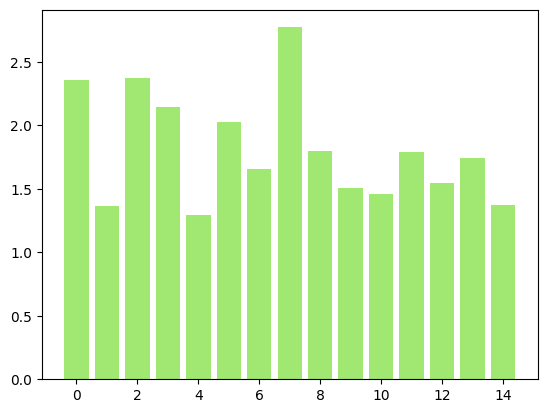

In [450]:
fig, ax = plt.subplots()
for i in np.arange(scores.shape[0]):
    ax.bar(i, scores[i], color= "#a0e872")
plt.show()

### Check-out flow

1. Customer approaches the register area
2. Customer queues at the register with the shortest line length
3. **Later feature**: While the customer is at the top of the stack, they can switch to another register with shorter line or fewer items, since now they have had a bit of time to survey the other registers' lines and the contents of their customers' carts
4. Each register processes customers at a rate of n seconds per item, which is a fixed cashier trait
   a. The processing rate can be increased by a constant multiplier if a bagger is added to register
   b. When register is empty (0 items), cashier can "add" a customer from a neighboring queue (FIFO)  
5. The store can open another register if it has the capacity 